In [1]:
import os
import gc
import sys
import warnings
import pickle
from pathlib import Path

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df_names = ['playerBoxScores', 'teamBoxScores', 'playerTwitterFollowers', 'teamTwitterFollowers', 'awards', 'events',
           'games', 'standings', 'rosters', 'transactions']
path = "data/train_vs/"

train_dict = {}
for index in range(len(df_names)):
    train_dict[df_names[index]] = pd.read_pickle(os.path.join(path,df_names[index]) + "_train.pkl")

In [3]:
df_names = ['seasons', 'teams', 'players', 'awards']
path = "data/"

my_dict = {}
for index in range(len(df_names)):
    my_dict[df_names[index]] = pd.read_csv(os.path.join(path,df_names[index]) + ".csv")

In [4]:
target_v = pd.read_pickle('data/target_v/nextDayPlayerEngagement_train.pkl')

In [5]:
target_dict = {id: target_v[target_v['playerId']==id].drop(
    ['index'], axis = 1) for id in target_v['playerId'].unique()}    

In [6]:
target_dict[112526].head(3)

,engagementMetricsDate,playerId,target1,target2,target3,target4,date
969,2018-01-02,112526,0.055277,5.496109,0.025839,16.176471,20180101
3556,2018-01-03,112526,0.060625,3.252914,0.030486,8.541353,20180102
5737,2018-01-04,112526,0.029341,1.648352,0.032613,10.490112,20180103


## Dictionary for playerBoxScores

In [7]:
perform_stats = pd.DataFrame()
perform_stats = train_dict['playerBoxScores'][[
    'playerId', 'gamePk', 'gameDate', 'gameTimeUTC', 'teamId', 'date']]
perform_stats.head(3)

,playerId,gamePk,gameDate,gameTimeUTC,teamId,date
0,605131,529418,2018-03-29,2018-03-29T23:08:00Z,119,20180329
1,605480,529406,2018-03-29,2018-03-29T20:00:00Z,139,20180329
2,546318,529416,2018-03-29,2018-03-29T20:10:00Z,143,20180329


In [321]:
train_dict['playerBoxScores'].columns

Index(['home', 'gamePk', 'gameDate', 'gameTimeUTC', 'teamId', 'teamName',
       'playerId', 'playerName', 'jerseyNum', 'positionCode', 'positionName',
       'positionType', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hit

In [335]:
performance = train_dict['playerBoxScores']

# Defense
perform_stats['FPCT'] = (performance['putOuts']+performance['assists']) / performance['chances']
perform_stats['Out'] = performance['putOuts'] + performance['groundOuts'] + performance['strikeOuts'] + performance['flyOuts']

# Offence
perform_stats['AB'] = performance['atBats']
perform_stats['B2'] = performance['doubles']
perform_stats['B3'] = performance['triples']
perform_stats['SB'] = performance['stolenBases']
perform_stats['CS'] = performance['caughtStealing']
perform_stats['H'] = performance['hits']
perform_stats['HR'] = performance['homeRuns']
perform_stats['IBB'] = performance['intentionalWalks']
perform_stats['HBP'] = performance['hitByPitch']
perform_stats['LOB'] = performance['leftOnBase']
perform_stats['PA'] = performance['plateAppearances']
perform_stats['TB'] = performance['totalBases']
perform_stats['GIDP'] = performance['groundIntoDoublePlay']
perform_stats['RBI'] = performance['rbi']
perform_stats['BB'] = performance['baseOnBalls']
perform_stats['SO'] = performance['strikeOuts']
perform_stats['AVG'] = perform_stats['H']/perform_stats['AB']


# Pitching
perform_stats['SV_percnt'] = performance['saves']/performance['saveOpportunities']
perform_stats['HLD'] = performance['holds']
perform_stats['BS'] = performance['blownSaves']
perform_stats['IR'] = performance['inheritedRunners']
perform_stats['IP'] = performance['inningsPitched']
perform_stats['ERA'] = (9*performance['earnedRuns'])/perform_stats['IP']
perform_stats['WHIP'] = (perform_stats['BB'] + perform_stats['H'])/perform_stats['IP']

# Advanced Offence
perform_stats['ISO'] = (perform_stats['B2']+2*perform_stats['B3']+3*perform_stats['HR'])/perform_stats['AB']
perform_stats['BABIP'] = (perform_stats['H'] - perform_stats['HR'])/(
    perform_stats['AB']-perform_stats['SO']-perform_stats['HR']+performance['sacFlies'])
perform_stats['RC'] = perform_stats['TB']*(perform_stats['H']+perform_stats['BB'])/(
    perform_stats['AB']+perform_stats['BB'])

perform_stats['PA/SO'] = perform_stats['PA']/perform_stats['SO']
perform_stats['K/BB'] = perform_stats['SO']/perform_stats['BB']

perform_stats['GS'] = 40+6*perform_stats['Out']+perform_stats['SO']-2*performance['baseOnBallsPitching']-2*performance['hitsPitching']-3*performance['runsPitching']-6*performance['homeRunsPitching']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [13]:
playerBS_dict = {id: perform_stats[perform_stats[
    'playerId']==id] for id in target_v['playerId'].unique()}    

In [14]:
merge_1  = {}
for key, df in target_dict.items():
    df = target_dict[key].merge(playerBS_dict[key], on = ['date', 'playerId'], how = 'left')
    merge_1[key] = df

In [15]:
train_dict.keys()

dict_keys(['playerBoxScores', 'teamBoxScores', 'playerTwitterFollowers', 'teamTwitterFollowers', 'awards', 'events', 'games', 'standings', 'rosters', 'transactions'])

In [16]:
# train_dict['teamBoxScores'].columns

In [17]:
select_awards = train_dict['awards'][['playerId', 'date', 'awardId']]

In [18]:
awards_dict = {id: select_awards[select_awards[
    'playerId']==id] for id in target_v['playerId'].unique()}    

In [19]:
merge_2  = {}
for key, df in target_dict.items():
    df = merge_1[key].merge(awards_dict[key], on = ['date', 'playerId'], how = 'left')
    merge_2[key] = df

In [20]:
select_stand = train_dict['standings'][['gameDate', 'divisionId', 'teamId', 'divisionRank', 'leagueRank', 'wildCardRank', 
                                         'pct', 'homeWins', 'xWinLossPct', 'date']]

In [21]:
# train_dict['standings'].head()
merge_3  = {}
for key, df in target_dict.items():
    df = merge_2[key].merge(select_stand, on = ['date', 'teamId', 'gameDate'], how = 'left')
    merge_3[key] = df

In [22]:
train_dict['rosters'].head(3)

,playerId,gameDate,teamId,statusCode,status,index,date
0,400121,2018-01-01,116,A,Active,0,20180101
1,408045,2018-01-01,142,A,Active,0,20180101
2,425492,2018-01-01,120,A,Active,0,20180101


In [23]:
select_rosters = train_dict['rosters'].drop(['status', 'index'], axis = 1)

In [24]:
rosters_dict = {id: select_rosters[select_rosters['playerId']==id] for id in target_v['playerId'].unique()}

In [25]:
merge_4  = {}
for key, df in target_dict.items():
    df = merge_3[key].merge(rosters_dict[key], on = ['date', 'playerId', 'teamId', 'gameDate'], how = 'left')
    merge_4[key] = df

In [26]:
select_games = train_dict['games'][['gamePk', 'gameType', 'gameTimeUTC', 'codedGameState', 'gameNumber',
                                   'homeId', 'homeWinPct', 'homeScore',]]

In [27]:
merge_5  = {}
for key, df in target_dict.items():
    df = merge_4[key].merge(select_games, on = ['gameTimeUTC', 'gamePk'], how = 'left')
    merge_5[key] = df

In [319]:
train_dict['teamBoxScores'].columns

Index(['home', 'teamId', 'gamePk', 'gameDate', 'gameTimeUTC', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'airOutsPitching', 'groundOutsPitching', 'runsPitching',
       'doublesPitching', 'triplesPitching', 'homeRunsPitching',
       'strikeOutsPitching', 'baseOnBallsPitching', 'intentionalWalksPitching',
       'hitsPitching', 'hitByPitchPitching', 'atBatsPitching',
       'caughtStealingPitching', 'stolenBasesPitching', 'inningsPitched',
       'earnedRuns', 'battersFaced', 'outsPitching', 'hitBatsmen', 'balks',
       'wildPitches', 'pickoffsPitching', 'rbiPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterference

In [ ]:
team_stats = pd.DataFrame()

In [339]:
performance_team = train_dict['teamBoxScores']
team_stats['Out_team'] = performance_team['groundOuts'] + performance_team['strikeOuts'] + performance_team['flyOuts']

# Offence
team_stats['AB_team'] = performance_team['atBats']
team_stats['B2_team'] = performance_team['doubles']
team_stats['B3_team'] = performance_team['triples']
team_stats['SB_team'] = performance_team['stolenBases']
team_stats['CS_team'] = performance_team['caughtStealing']
team_stats['H_team'] = performance_team['hits']
team_stats['HR_team'] = performance_team['homeRuns']
team_stats['IBB_team'] = performance_team['intentionalWalks']
team_stats['HBP_team'] = performance_team['hitByPitch']
team_stats['LOB_team'] = performance_team['leftOnBase']
team_stats['PA_team'] = performance_team['plateAppearances']
team_stats['TB_team'] = performance_team['totalBases']
team_stats['GIDP_team'] = performance_team['groundIntoDoublePlay']
team_stats['RBI_team'] = performance_team['rbi']
team_stats['BB_team'] = performance_team['baseOnBalls']
team_stats['SO_team'] = performance_team['strikeOuts']
team_stats['AVG_team'] = team_stats['H']/team_stats['AB']


# Pitching
team_stats['IR_team'] = performance_team['inheritedRunners']
team_stats['IP_team'] = performance_team['inningsPitched']
team_stats['ERA_team'] = (9*performance_team['earnedRuns'])/team_stats['IP']
team_stats['WHIP_team'] = (team_stats['BB'] + team_stats['H'])/team_stats['IP']

# Advanced Offence
team_stats['ISO'] = (team_stats['B2']+2*team_stats['B3']+3*team_stats['HR'])/team_stats['AB']
team_stats['BABIP'] = (team_stats['H'] - team_stats['HR'])/(
    team_stats['AB']-team_stats['SO']-team_stats['HR']+performance_team['sacFlies'])
team_stats['RC'] = team_stats['TB']*(team_stats['H']+team_stats['BB'])/(
    team_stats['AB']+team_stats['BB'])

team_stats['PA/SO'] = team_stats['PA']/team_stats['SO']
team_stats['K/BB'] = team_stats['SO']/team_stats['BB']

In [340]:
team_stats['Pytha_WR'] = train_dict['teamBoxScores']['runsScored']**2/(
    train_dict['teamBoxScores']['runsScored']**2 + train_dict['teamBoxScores']['runsPitching']**2)

In [341]:
team_stats.

,Pytha_WR,IBB_team,Out_team,AB,B2,B3,SB,CS,H,HR,...,AVG,IR,IP,ERA,WHIP,ISO,BABIP,RC,PA/SO,K/BB
0,0.941176,0,24,36,2,1,2,0,12,0,...,0.333333,0,9.0,2.00,2.000000,0.111111,0.480000,6.857143,3.818182,1.833333
1,0.200000,0,21,30,1,0,2,0,5,0,...,0.166667,0,8.0,2.25,0.875000,0.033333,0.227273,1.312500,4.500000,4.000000
2,0.835052,0,20,33,2,0,1,0,12,0,...,0.363636,0,9.0,4.00,2.333333,0.060606,0.480000,7.000000,5.500000,0.888889
3,0.692308,0,19,28,1,1,0,0,4,0,...,0.142857,0,9.0,4.00,1.222222,0.107143,0.235294,2.200000,3.181818,1.571429
4,0.058824,0,22,31,1,0,0,0,6,0,...,0.193548,0,9.0,4.00,0.888889,0.032258,0.272727,1.696970,3.777778,4.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12523,0.952941,0,20,41,3,1,0,0,15,1,...,0.365854,0,9.0,2.00,2.000000,0.195122,0.437500,9.409091,5.000000,3.000000
12524,0.871134,0,18,38,1,0,1,0,14,6,...,0.368421,0,9.0,5.00,2.333333,0.500000,0.307692,15.400000,7.666667,0.857143
12525,1.000000,0,18,38,2,0,0,0,15,5,...,0.394737,0,9.0,0.00,2.222222,0.447368,0.357143,14.883721,8.600000,1.000000
12526,0.753846,0,20,35,2,0,2,0,10,3,...,0.285714,0,9.0,4.00,1.777778,0.314286,0.333333,8.195122,3.727273,1.833333


In [61]:
# train_dict['events'].columns

In [44]:
select_events = train_dict['events'][['gamePk', 'gameDate', 'gameTimeUTC','gameType', 'eventId', 
                                      'inning', 'halfInning', 'homeScore', 'pitcherTeamId', 
                                     'hitterTeamId', 'pitchType', 'pitchType', 'date']]

In [ ]:
# merge_6  = {}
# for key, df in target_dict.items():
#     df = merge_5[key].merge(select_events, on = ['gamePk', 'gameDate', 'gameTimeUTC','gameType'], how = 'left')
#     merge_6[key] = df

## Construct whole df

In [84]:
df = pd.concat(df_list ,axis=0)

In [89]:
df = df.drop(['gamePk', 'gameDate', 'gameTimeUTC'], axis = 1)

In [124]:
object_encode = df.select_dtypes(include=['object']).drop(['engagementMetricsDate', 'pct'], axis = 1)

In [ ]:
df['pct'] = df['pct'].astype('float')

In [126]:
def label_encode(df, column):
    func = {c: i for i, c in enumerate(df[column].unique()) if not pd.isna(c)}
    df[column] = df[column].map(func)

In [127]:
for col in object_encode.columns:
    label_encode(object_encode, col)

In [130]:
df[object_encode.columns] = object_encode

In [159]:
label_encode(df, 'date')

In [142]:
df = df.drop(['teamId'], axis = 1)
df = df.fillna(-99)
df = df[df.columns.difference(['engagementMetricsDate'])].astype('float32')

In [ ]:
df.replace(np.inf, 0, inplace=True)

## RandomForest Model

In [87]:
from sklearn.ensemble import RandomForestRegressor

In [279]:
X_pre = df[df.columns.difference(['engagementMetricsDate', 'target1', 'target2', 'target3', 'target4', 'date'])]
y = df[['playerId','target1', 'target2', 'target3', 'target4']]

In [246]:
X_dict = {id: X_pre[X_pre['playerId']==id] for id in target_v['playerId'].unique()} 

In [272]:
regr = RandomForestRegressor(
    max_depth=8, 
    max_features = 'sqrt', 
    min_samples_split = 6, 
    n_estimators = 100, 
    random_state=0)

In [283]:
fit_try = regr.fit(X_pre,y)

### Start feature importances plots

In [312]:
modelpath1 = 'rf_models/y1' 
if not os.path.exists(modelpath1):
    os.makedirs(modelpath1)
    
modelpath2 = 'rf_models/y2' 
if not os.path.exists(modelpath2):
    os.makedirs(modelpath2)
    
modelpath3 = 'rf_models/y3' 
if not os.path.exists(modelpath3):
    os.makedirs(modelpath3)
    
modelpath4 = 'rf_models/y4' 
if not os.path.exists(modelpath4):
    os.makedirs(modelpath4)
    
figpath = 'plots/' 
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [307]:
regr_dict_y1 = {}
feature_imp_y1 = pd.DataFrame(columns = X_dict[112526].drop(['playerId'], axis = 1).columns).T
for key, item in X_dict.items():
    regr_dict_y1[key] = regr.fit(X_dict[key].drop(['playerId'], axis = 1), y[y['playerId'] == key]['target1'])
    feature_imp_y1[key] = regr_dict_y1[key].feature_importances_
    filename = modelpath1 + str(key)+'_model.sav'
    pickle.dump(regr_dict_y1[key], open(filename, 'wb'))

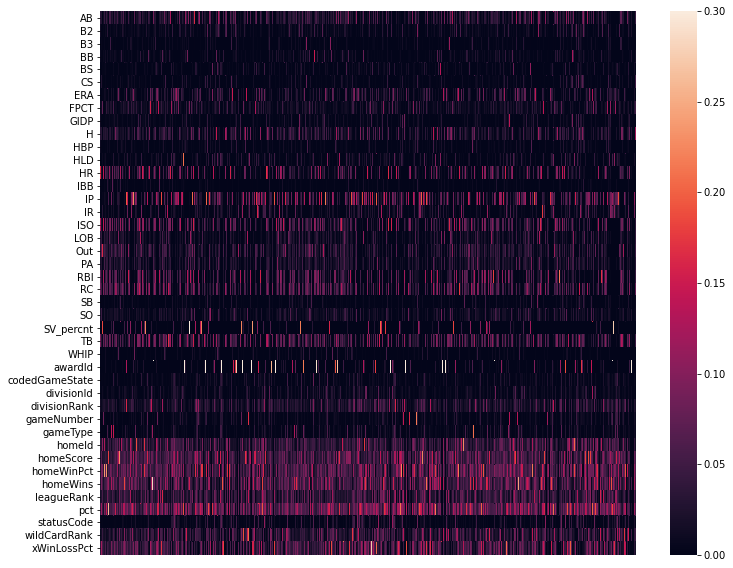

In [309]:
plt.figure(figsize = (12,10))
sns.heatmap(feature_imp_y1, vmax = 0.3, xticklabels=False)
plt.savefig('plots/y1_feat.jpg')

In [313]:
regr_dict_y2 = {}
feature_imp_y2 = pd.DataFrame(columns = X_dict[112526].drop(['playerId'], axis = 1).columns).T
for key, item in X_dict.items():
    regr_dict_y2[key] = regr.fit(X_dict[key].drop(
        ['playerId'], axis = 1), y[y['playerId'] == key]['target2'])
    feature_imp_y2[key] = regr_dict_y2[key].feature_importances_
#     filename = modelpath2 + str(key)+'_model.sav'
#     pickle.dump(regr_dict_y2[key], open(filename, 'wb'))

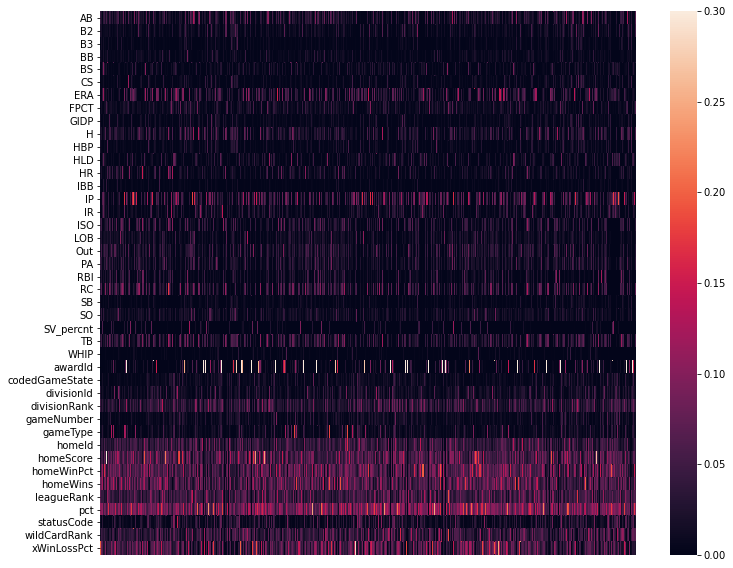

In [314]:
plt.figure(figsize = (12,10))
sns.heatmap(feature_imp_y2, vmax = 0.3, xticklabels=False)
# plt.savefig('plots/y2_feat.jpg')

In [315]:
regr_dict_y3 = {}
feature_imp_y3 = pd.DataFrame(columns = X_dict[112526].drop(['playerId'], axis = 1).columns).T
for key, item in X_dict.items():
    regr_dict_y3[key] = regr.fit(X_dict[key].drop(
        ['playerId'], axis = 1), y[y['playerId'] == key]['target3'])
    feature_imp_y3[key] = regr_dict_y3[key].feature_importances_
#     filename = modelpath3 + str(key)+'_model.sav'
#     pickle.dump(regr_dict_y3[key], open(filename, 'wb'))

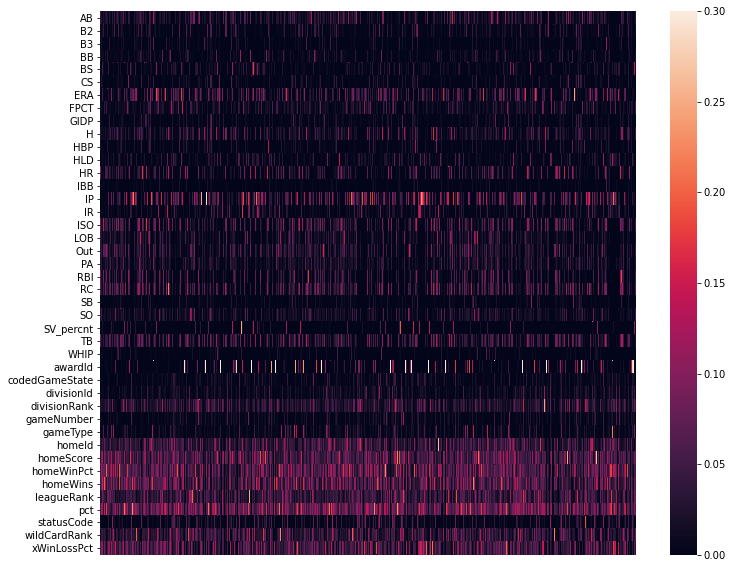

In [316]:
plt.figure(figsize = (12,10))
sns.heatmap(feature_imp_y3, vmax = 0.3, xticklabels=False)
# plt.savefig('plots/y3_feat.jpg')

In [317]:
regr_dict_y4 = {}
feature_imp_y4 = pd.DataFrame(columns = X_dict[112526].drop(['playerId'], axis = 1).columns).T
for key, item in X_dict.items():
    regr_dict_y4[key] = regr.fit(X_dict[key].drop(
        ['playerId'], axis = 1), y[y['playerId'] == key]['target4'])
    feature_imp_y4[key] = regr_dict_y4[key].feature_importances_
#     filename = modelpath4 + str(key)+'_model.sav'
#     pickle.dump(regr_dict_y4[key], open(filename, 'wb'))

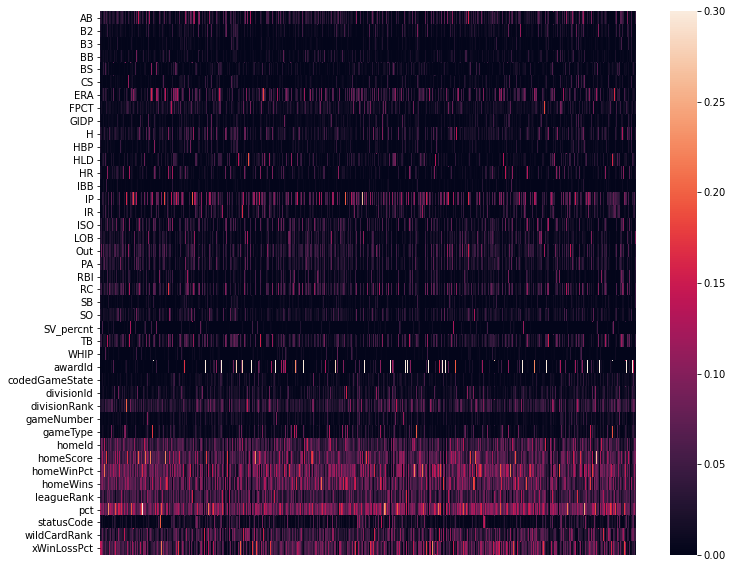

In [318]:
plt.figure(figsize = (12,10))
sns.heatmap(feature_imp_y4, vmax = 0.3, xticklabels=False)
# plt.savefig('plots/y4_feat.jpg')

### Add twitter columns 